# Filtering the dataset
### - Removing datapoints older than year 2018
### - Removing datapoints of closed restaurants

In [ ]:
import pandas as pd
from tqdm import tqdm

# Define the file path to your original CSV file
input_file_path = 'data/precovid_reviews.csv'

# Define the file path for the new filtered CSV file
output_file_path = 'filtered_reviews_open2018_2019.csv'

# Define the chunk size for processing
chunk_size = 10000

# Initialize a counter for the total number of rows in the new dataset
total_rows = 0

# Open the output file for writing
with open(output_file_path, 'w', encoding='utf-8') as output_file:  # Set encoding to 'utf-8'
    # Process the file in chunks
    for chunk in tqdm(pd.read_csv(input_file_path, chunksize=chunk_size)):
        # Convert 'date_' column to datetime
        chunk['date_'] = pd.to_datetime(chunk['date_'], errors='coerce')

        # Filter rows where the year is 2018 or 2019, and 'is_open' is 1
        filtered_chunk = chunk[(chunk['is_open'] == 1) & (chunk['date_'].dt.year.isin([2018, 2019]))]

        # Update the total row counter
        total_rows += len(filtered_chunk)

        # Append the filtered chunk to the output file
        filtered_chunk.to_csv(output_file, index=False, mode='a', header=output_file.tell() == 0, encoding='utf-8')  # Write header only for the first chunk

# Print the total number of rows in the new dataset
print(f"Number of rows in the filtered dataset: {total_rows}")


### Output: A filtered .csv file 'filtered_reviews_open2018_2019' 

# Creating the graph from the filtered dataset

In [23]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import pickle

# Set the file path to your dataset
file_path = 'filtered_reviews_open2018_2019.csv'

# Initialize an empty graph
G = nx.Graph()

# Define the chunk size (adjust based on memory availability)
chunk_size = 10000

# Loop through the file in chunks
for chunk in tqdm(pd.read_csv(file_path, usecols=['business_id', 'user_id'], chunksize=chunk_size)):
    # Iterate over each user group in the chunk
    for user_id, group in chunk.groupby('user_id'):
        # Get the list of business names that this user reviewed
        businesses = group['business_id'].tolist()

        # Connect each business (restaurant) that the user has reviewed to every other business they reviewed
        for i in range(len(businesses)):
            for j in range(i + 1, len(businesses)):
                business_a = businesses[i]
                business_b = businesses[j]
                
                # Add an edge between the two businesses
                G.add_edge(business_a, business_b)

# Get the number of nodes (restaurants) and edges (connections between restaurants)
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the results
print(f"Number of restaurants (nodes): {num_nodes}")
print(f"Number of connections (edges): {num_edges}")

# Save the graph for future use
with open('business_graph.pkl', 'wb') as f:
    pickle.dump(G, f)


121it [01:27,  1.38it/s]

Number of restaurants (nodes): 21009
Number of connections (edges): 53837


### Looking at degree distribution for choosing a link threshold for nodes

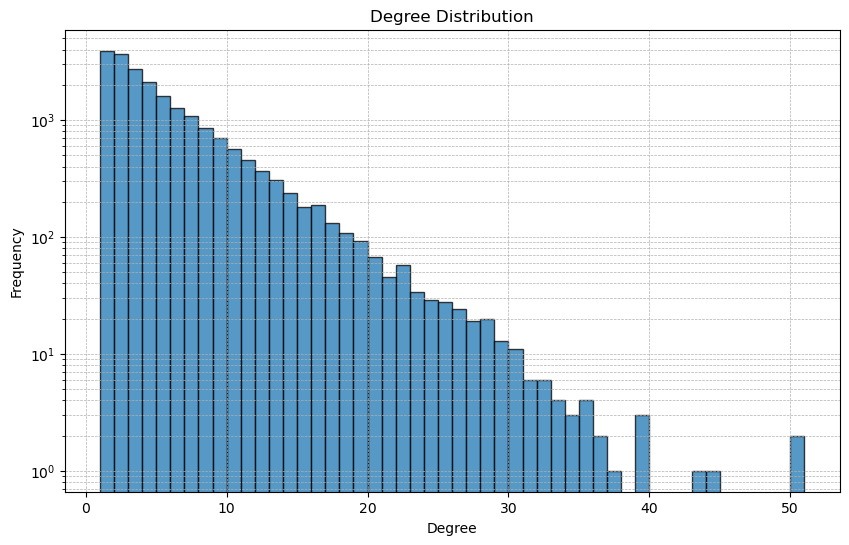

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the graph from the pickle file
with open('business_graph.pkl', 'rb') as f:
    G = pickle.load(f)

# Calculate degree for each node
degrees = [deg for _, deg in G.degree()]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, edgecolor='black', alpha=0.75)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

### Looking at threshold vs. nodes/links
Determining a suitable threshold by analyzing where significant changes occur in the number of nodes and edges as the threshold increases.  

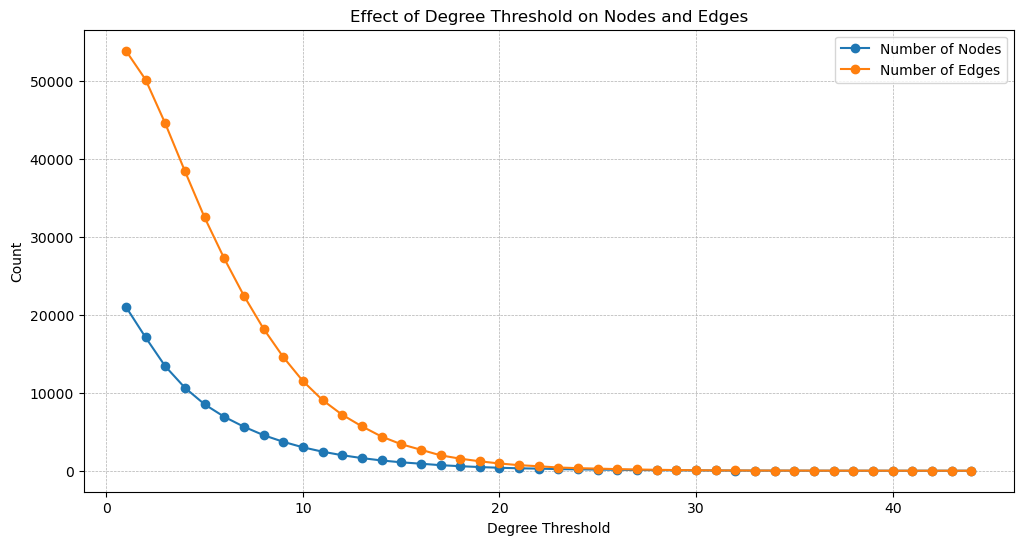

In [ ]:
# Load the graph
with open('business_graph.pkl', 'rb') as f:
    G = pickle.load(f)

# Initialize lists to store the number of nodes and edges for different thresholds
thresholds = range(1, 45)  # Adjust range based on the maximum degree in your network
num_nodes = []
num_edges = []

# Compute nodes and edges for each threshold
for threshold in thresholds:
    # Filter nodes with degree >= threshold
    filtered_nodes = [node for node, degree in G.degree() if degree >= threshold]
    G_filtered = G.subgraph(filtered_nodes)
    
    # Store the number of nodes and edges
    num_nodes.append(G_filtered.number_of_nodes())
    num_edges.append(G_filtered.number_of_edges())

# Plot the results
plt.figure(figsize=(12, 6))

# Number of nodes vs threshold
plt.plot(thresholds, num_nodes, marker='o', label='Number of Nodes')

# Number of edges vs threshold
plt.plot(thresholds, num_edges, marker='o', label='Number of Edges')

# Add labels and legend
plt.title("Effect of Degree Threshold on Nodes and Edges")
plt.xlabel("Degree Threshold")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


# Validation of our threshold choice 
From the graph we decide to use a threshold of **5**. Which is suitable as we want to remove most low-degree nodes while retaining a reasonably sized network for our analysis. At this point, the number of edges is still substantial, and the core structure of the network remains intact.

We perform additional validation of our choosen threshold value by looking at clustering and the largest network component, to make sure the threshold don't remove important data for our analysis. 

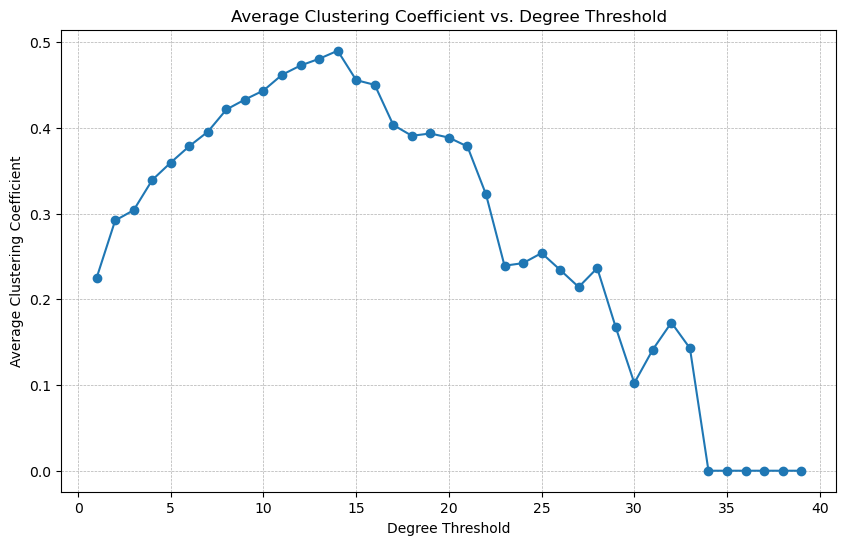

In [32]:
# Load the graph
with open('business_graph.pkl', 'rb') as f:
    G = pickle.load(f)

# Initialize lists to store results
thresholds = range(1, 40)  # Adjust range as needed
average_clustering = []

# Compute the average clustering coefficient for each threshold
for threshold in thresholds:
    # Filter nodes with degree >= threshold
    filtered_nodes = [node for node, degree in G.degree() if degree >= threshold]
    G_filtered = G.subgraph(filtered_nodes)
    
    # Calculate average clustering coefficient
    avg_clustering = nx.average_clustering(G_filtered)
    average_clustering.append(avg_clustering)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, average_clustering, marker='o')
plt.title("Average Clustering Coefficient vs. Degree Threshold")
plt.xlabel("Degree Threshold")
plt.ylabel("Average Clustering Coefficient")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


We are looking for a threshold where the clustering coefficient stabilizes or decreases minimally. A sharp drop may indicate that key local structures (clusters) are being lost.

We see drops ocurring after 14, which indicates that clusters aren't lost with a threshold of 5.  

**Next** we look at the largest component for different thresholds. 

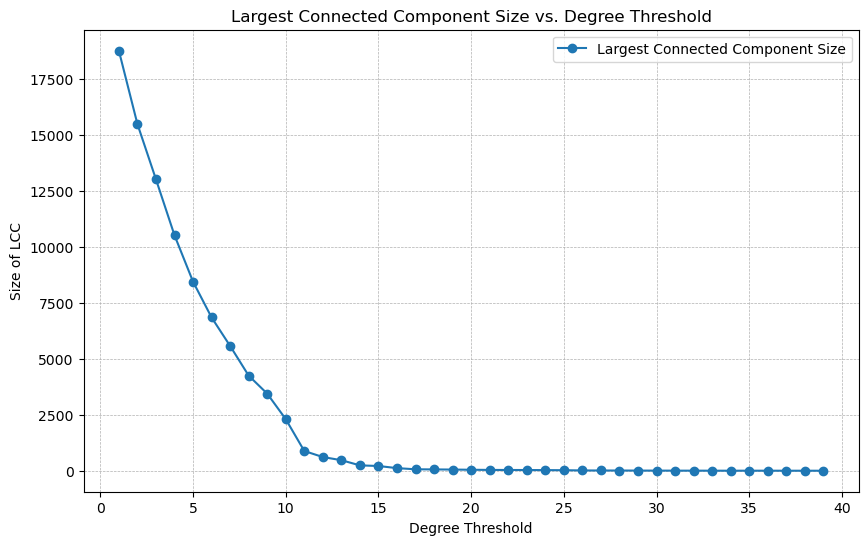

In [33]:
# Initialize lists to store results
largest_cc_sizes = []

# Compute the size of the largest connected component for each threshold
for threshold in thresholds:
    # Filter nodes with degree >= threshold
    filtered_nodes = [node for node, degree in G.degree() if degree >= threshold]
    G_filtered = G.subgraph(filtered_nodes)
    
    # Calculate the size of the largest connected component
    if len(G_filtered) > 0:  # Avoid errors for empty graphs
        lcc = max(nx.connected_components(G_filtered), key=len)
        largest_cc_sizes.append(len(lcc))
    else:
        largest_cc_sizes.append(0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, largest_cc_sizes, marker='o', label="Largest Connected Component Size")
plt.title("Largest Connected Component Size vs. Degree Threshold")
plt.xlabel("Degree Threshold")
plt.ylabel("Size of LCC")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In the plot we look for a steep decline in the LCC size, as it indicates fragmentation of the network. We need to choose a threshold where the LCC size remains large enough to retain a meaningful network. 

We can see that the size of the LCC is above. 7500 with a threshold of 5, wich is ideal as we want to retain more of the network’s structure while still reducing noise from low-degree nodes.

### Network graph with applied threshold

In [36]:
# Load the saved graph
with open('business_graph.pkl', 'rb') as f:
    G = pickle.load(f)

# Apply the threshold: Remove nodes with degree < 5
nodes_to_remove = [node for node, degree in G.degree() if degree < 5]
G.remove_nodes_from(nodes_to_remove)

# Get updated network properties
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the results
print(f"Number of restaurants (nodes) after applying threshold: {num_nodes}")
print(f"Number of connections (edges) after applying threshold: {num_edges}")

# Save the filtered graph
with open('business_graph_threshold.pkl', 'wb') as f:
    pickle.dump(G, f)

Number of restaurants (nodes) after applying threshold: 8512
Number of connections (edges) after applying threshold: 32471


### We now have a graph ready for analysis - communities, sentiment analysis, etc. 